In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC
import statsmodels.api as sm
import seaborn as sns

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import pickle


## Model Maker Class

In [2]:
class aviation_data_model:
    def __init__(self, x, y, drop_categories = None, test_size = 0.3, random_state = 2023):
        self.x = x.copy()
        self.drop_categories = drop_categories
        self.y = y
        self.random_state = random_state
        self.test_size = test_size
        self.model = None
        self.x_oh = None
        self.x_con = None
        self.results = None
        self.pvalues = None
        self.X_test = None
        self.Y_test = None

        
    def one_hot(self):
        #Check to see if dummy parameter passed correctly
        if type(self.drop_categories[0]) == tuple:
            
            categories = []
            for i, j in self.drop_categories:
                # Collect subset of columns to dummify
                categories.append(i)
                
                # If a specific drop value has been given for a column, add a 0- to it so it is 'first' and drops accordingly
                if j != 'first':
                    self.x[i] = np.where(self.x[i] == j, '0-' + j, self.x[i])
        else:
            raise TypeError('Invalid OneHotEncoder values. Use None or a list of tuples of (column name, category name')
            
        self.x_oh = pd.get_dummies(data= self.x, columns = categories, drop_first=True)
        # Log line - uncomment below to check shapes after important steps
        # print(f"OneHot Resulting Shape: {self.x_oh.shape}")
        return self.x_oh
    
    def train_test(self, x, y):
        X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=self.test_size, random_state=self.random_state)
        return (X_train, X_test, y_train, y_test)
        
    
    def fit_binomial(self, link = 'logit'):
        # Start with OneHotEncoding if given
        if self.drop_categories:
            model_x = self.one_hot()
        else:
            model_x = self.x
            
        # Add column for constant per statsmodels GLM requirements
        x_con = sm.add_constant(model_x[list(model_x.columns)])
        self.x_con = x_con
        
        # Log line - uncomment below to check shapes after important steps
        # print(f"After constant Resulting Shape: {self.x_con.shape}")
        
        #Train Test Split
        X_train, X_test, y_train, y_test = self.train_test(x_con, self.y)

        
        # Log lines - uncomment below to check shapes after important steps
        # print(f"After tts X_train Resulting Shape: {X_train.shape}")
        # print(f"After tts X_test Resulting Shape: {X_test.shape}")
        # print(f"After tts y_train Resulting Shape: {y_train.shape}")
        # print(f"After tts y_test Resulting Shape: {y_test.shape}")
        
        if link == 'logit':
            link_function = sm.families.links.Logit()
        elif link == 'probit':
            link_function = sm.families.links.Probit()
        
        #Make and fit a model
        glm_bin = sm.GLM(
            y_train,
            X_train,
            family=sm.families.Binomial(link=link_function)).fit()
        
        #Stash results as accessible attributes
        self.results = glm_bin.summary()
        self.model = glm_bin
        self.pvalues = np.round(glm_bin.pvalues, 6).to_frame().sort_values(by = 0)
        self.pvalues.rename({0: 'p_values'}, axis =1 , inplace=True)
        self.X_test = X_test
        self.y_test = y_test

In [3]:
def glm_accuracy(model, x, y):
    test_pred = model.predict(x)
    test_pred = test_pred.map(lambda x: 1 if x >=0.50 else 0)
    acc = pd.concat([test_pred, y], axis = 1)
    return acc[acc.iloc[:, 0] == acc.iloc[:, 1]].shape[0] / y.shape[0]

In [4]:
def is_top_model(data, model, top_x):
    top_list = list(data['model'].value_counts()[:top_x + 1].index.str.upper())
    return True if model.upper() in top_list else False

In [5]:
def is_top_make(data, make, top_x):
    top_list = list(data['make'].value_counts()[:top_x + 1].index.str.upper())
    return True if make.upper() in top_list else False

In [6]:
def is_top_family(data, family, top_x):
    top_list = list(data['aircraft_family'].value_counts()[:top_x + 1].index.str.upper())
    return True if family.upper() in top_list else False

In [7]:
def is_top_city(data, city, top_x):
    top_list = list(data['city'].value_counts()[:top_x + 1].index.str.upper())
    return True if city.upper() in top_list else False

In [8]:
# def bundler(val, top_n):
#     top_list = list(data.value_counts()[:top_n + 1].index.str.upper())
#     new_data = np.where(data.str.upper().isin(top_list), data.str.upper(), 'UNCOMMON' )
#     return new_data

### Read in data

In [9]:
df = pd.read_csv('../datasets/alaska_single_engine_clean.csv')

## Binarize, bundle, and engineer

Group 'UNK' and 'Unknown'

In [10]:
df['purpose_of_flight'] = df['purpose_of_flight'].map(lambda x: 'UNK' if x=='Unknown' else x)

In [11]:
df['scheduled'] = df['scheduled'].map(lambda x: 'UNK' if x == 'Unknown' else x)

The following lines are designed to help balance out categorical values, since there are many infrequent occurrences as well as very common occurrences. They set a cutoff in terms of the most frequent values, and anything outside of that gets lumped together as some variant of "Uncommon"

In [12]:
df['model'] = [x.upper() if is_top_model(df, x,200) else 'UNCOMMON MODEL' for x in df['model']]

In [13]:
df['make'] = [x.upper() if is_top_make(df, x,50) else 'UNCOMMON MAKE' for x in df['make']]


In [14]:
df['city'] = [x.upper() if is_top_city(df, x,75) else 'UNCOMMON CITY' for x in df['city']]

In [15]:
df['aircraft_category'].value_counts()

AIR         5271
HELI         303
ULTR           5
WSFT           4
GYRO           3
GLI            2
UNMANNED       1
PPAR           1
Name: aircraft_category, dtype: int64

### Drop everything that isn't a airplane or helicoper

In [16]:
df.drop( df[~df['aircraft_category'].isin(['AIR', 'HELI'])].index, inplace = True)

## Manual GLM Attempt with multiple features

### Create X

In [17]:
X_1a = df.drop(['ntsb_no', 'probable_cause', 'airport_name', 'event_type', 'mkey', 'city', 'n', 'has_safety_rec', 'report_type', 'highest_injury_level', 'fatal_injury_count', 'serious_injury_count', 'minor_injury_count', 'airport_id', 'far', 'aircraft_damage', 'operator', 'event_year', 'event_season', 'event_day', 'aircraft_category', 'has_injury', 'event_time','has_aircraft_damage', 'is_accident', 'make_model', 'has_fatal_injury', 'aircraft_family'], axis=1)

In [18]:
X_1a.head()

,latitude,longitude,make,model,amateur_built,scheduled,purpose_of_flight,weather_condition,event_month,event_hour,occurred_near_airport
0,61.775160,-152.15263,CESSNA,UNCOMMON MODEL,0,UNK,PERS,Unknown,9,8,0
1,60.805019,-161.78648,PIPER,PA-18-150,0,UNK,PERS,Unknown,9,12,0
2,59.646929,-151.49323,CESSNA,A185F,0,UNK,BUS,VMC,9,13,1
3,64.267579,-147.68704,HELIO,H-295,0,NSCH,BUS,Unknown,9,16,0
4,64.650753,-149.83639,UNCOMMON MAKE,UNCOMMON MODEL,1,UNK,PERS,VMC,9,15,0


### Create Y

In [19]:
df['highest_injury_level'].value_counts()

None Reported    4000
Minor             625
Fatal             573
Serious           376
Name: highest_injury_level, dtype: int64

In [20]:
df['highest_injury_level'] = np.where(
    df['highest_injury_level'].str.contains('None Reported') |
    df['highest_injury_level'].str.contains('Minor'),
    0,
    1)

In [21]:
y = df['highest_injury_level']
# y = df['has_fatal_injury']

### Create dummies

In [22]:
X_1a_dummy = pd.get_dummies(data=X_1a,
                         columns=['make',
                                  'model',
                                  'scheduled',
                                  'purpose_of_flight',
                                  'weather_condition',
                                  'event_month',
                                  'event_hour'
                                 ],
                         drop_first=True
        )

In [23]:
X_1a_dummy.shape

(5574, 311)

### Add constant for use in GLM

In [24]:
X_1a_con = sm.add_constant(X_1a_dummy[list(X_1a_dummy.columns)])

In [25]:
X_1a_con.shape

(5574, 312)

### Train test split

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X_1a_con, y, random_state=2023)

In [27]:
X_train.shape

(4180, 312)

In [28]:
glm_bin = sm.GLM(
    y_train,
    X_train,
    family=sm.families.Binomial(link=sm.families.links.Logit())).fit()

In [29]:
glm_bin_results = glm_bin.summary()

### Check accuracy

In [30]:
glm_accuracy(glm_bin, X_test, y_test)

0.8357245337159254

In [31]:
1 - y.mean()

0.8297452457839971

### Result: Accuracy does technically outperform baseline - p-values can be trusted

In [32]:
glm_bin_pvalues = np.round(glm_bin.pvalues, 4).to_frame().sort_values(by =  0, ascending = True)

In [33]:
glm_bin_coef_df = glm_bin.params.to_frame().sort_values(by = 0, ascending = False)

In [34]:
glm_bin_pvalues.rename({0: 'p_value'}, axis = 1, inplace=True)

In [35]:
glm_bin_coef_df.rename({0: 'coef'}, axis = 1, inplace=True)

In [36]:
glm_bin_pvalues.head(30)

,p_value
weather_condition_VMC,0.0000
occurred_near_airport,0.0000
event_hour_12,0.0005
event_hour_13,0.0024
event_hour_18,0.0031
event_hour_16,0.0031
event_hour_17,0.0035
event_hour_14,0.0074
event_hour_11,0.0076
event_hour_20,0.0091


In [37]:
# glm_bin_pvalues.to_csv('../results/glm_pvalues_manyfeatures_severe_and_fatal_y.csv')

## Trying again with modified predictor variables using aviation_model class

In [38]:
X_1b = df.drop(['ntsb_no', 'probable_cause', 'airport_name', 'event_type', 'mkey', 'n', 'has_safety_rec', 'report_type', 'highest_injury_level', 'fatal_injury_count', 'serious_injury_count', 'minor_injury_count', 'airport_id', 'far', 'aircraft_damage', 'operator', 'event_year', 'event_season', 'event_day', 'aircraft_category', 'has_injury', 'event_time','has_aircraft_damage', 'is_accident', 'make_model', 'make', 'model', 'has_fatal_injury'], axis=1)

In [39]:
# y = df['highest_injury_level']
y = df['has_fatal_injury']

In [40]:
X_1b.columns

Index(['city', 'latitude', 'longitude', 'amateur_built', 'scheduled',
       'purpose_of_flight', 'weather_condition', 'event_month', 'event_hour',
       'occurred_near_airport', 'aircraft_family'],
      dtype='object')

In [41]:
glm1z = aviation_data_model(X_1b, y, [
    ('city', 'first'),
    ('scheduled', 'UNK'),
    ('purpose_of_flight', 'UNK'),
    ('weather_condition', 'Unknown'),
    ('event_month', 'first'),
    ('event_hour', 'first'),
    ('aircraft_family', 'first')
], test_size=0.2)

In [42]:
glm1z.fit_binomial()

In [43]:
y.mean()

0.10279870828848224

In [44]:
glm_accuracy(glm1z.model, glm1z.X_test, glm1z.y_test)

0.8932735426008969

In [45]:
glm1z.pvalues.head(30)

,p_values
weather_condition_VMC,0.000000
occurred_near_airport,0.000002
event_hour_12,0.000026
event_hour_15,0.000084
event_hour_11,0.000091
event_hour_16,0.000102
event_hour_14,0.000118
event_hour_13,0.000126
event_hour_18,0.000234
event_hour_17,0.000246


In [46]:
# glm1z.pvalues.to_csv('../results/glm_pvalues_largefeatureset2_severe_and_fatal_y_acc838.csv')

In [47]:
y_pred_proba = glm1z.model.predict(glm1z.X_test)

In [48]:
y_pred = np.where(y_pred_proba >= 0.5, 1, 0)

In [49]:
    def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
      
        matrix = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(10,7))
        sns.heatmap(matrix, annot=True, fmt='g', cmap="Blues", 
                    xticklabels=['Predicted No Fatalities', 'Predicted Fatalities'], 
                    yticklabels=['Actually No Fatalities', 'Actually Had Fatalities'])
        plt.title(title)
        plt.show()

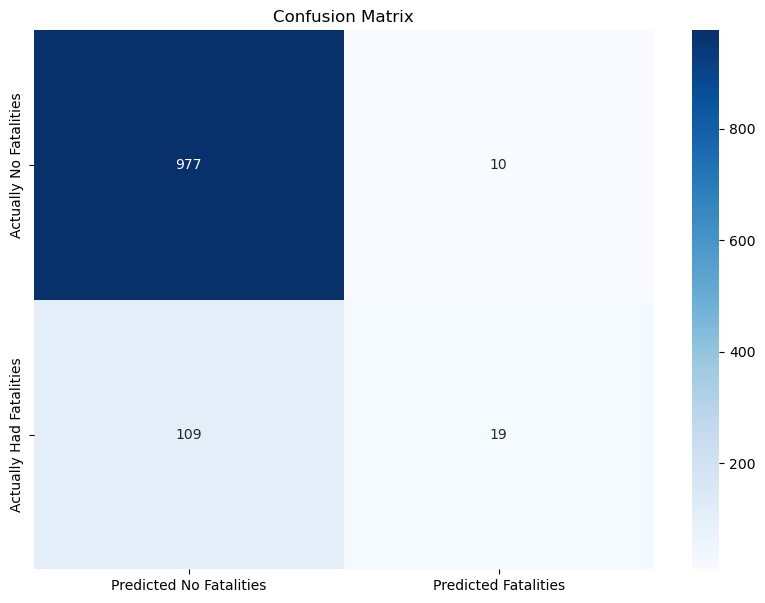

In [50]:
plot_confusion_matrix(glm1z.y_test, y_pred)

## Round 2 - Rapid Fire P Values

## 1 - Weather Condition

In [52]:
y = df['highest_injury_level']

In [53]:
X = df[['weather_condition']]

In [54]:
X.dtypes

weather_condition    object
dtype: object

In [55]:
y.value_counts()

0    4625
1     949
Name: highest_injury_level, dtype: int64

In [56]:
# X['purpose_of_flight'].value_counts()

In [57]:
glm1a = aviation_data_model(X, y,[
    ('weather_condition', 'Unknown')
])

In [58]:
glm1a.fit_binomial()

In [59]:
# glm1a.pvalues.to_csv('../results/glm_pvalues_weather_severe_and_fatal_y.csv')

In [60]:
np.exp(glm1a.model.params)

const                    1.600000
weather_condition_IMC    0.669248
weather_condition_VMC    0.097249
dtype: float64

## 2 - Aircraft Family

In [61]:
X_2 = df[['aircraft_family']]

In [62]:
y = df['highest_injury_level']

In [63]:
glm2a = aviation_data_model(X_2, y, drop_categories=[('aircraft_family', 'first')])

In [64]:
glm2a.fit_binomial()

In [65]:
glm2a_pvalues = glm2a.pvalues

In [66]:
glm2a_pvalues.head(10)

,p_values
const,0.022061
aircraft_family_PIPER PA-22 TRI-PACER,0.083334
aircraft_family_PIPER PA-20 PACER,0.126678
aircraft_family_HELIO COURIER,0.214003
aircraft_family_BELL 206,0.263177
aircraft_family_CESSNA 172 SKYHAWK,0.293607
aircraft_family_TAYLORCRAFT F-19 SPORTSMAN,0.325284
aircraft_family_CHAMPION/ BELLANCA/ AMERICAN CHAMPION SCOUT,0.342754
aircraft_family_CESSNA 170,0.378787
aircraft_family_CESSNA 180 SKYWAGON,0.423095


In [67]:
# glm2a_pvalues.to_csv('../results/glm_pvalues_aircraftfamily_severe_and_fatal_y.csv')

## 3 - Latitude and Longitude

In [68]:
X_3 = df[['latitude', 'longitude']]

In [69]:
y = df['highest_injury_level']

In [70]:
glm3a = aviation_data_model(X_3, y)

In [71]:
X_3.dtypes

latitude     float64
longitude    float64
dtype: object

In [72]:
glm3a.fit_binomial()

In [73]:
glm3a.pvalues

,p_values
const,0.000000
longitude,0.836955
latitude,0.850515


## 4 - City

In [74]:
X_4 = df[['city']]

In [122]:
y = df['highest_injury_level']

In [76]:
glm4a = aviation_data_model(X_4, y, [
    ('city', 'first')
])

In [77]:
glm4a.fit_binomial()

In [78]:
glm4a.pvalues

,p_values
city_KING SALMON,0.097559
city_FAIRBANKS,0.097734
city_TOK,0.147633
city_ANCHORAGE,0.166900
city_NENANA,0.172152
...,...
city_NONDALTON,0.892844
city_MCGRATH,0.942403
city_NAKNEK,0.998966
city_GALENA,0.999156


In [124]:
1 - y.mean()

0.8297452457839971

In [125]:
glm_accuracy(glm4a.model, glm4a.X_test, glm4a.y_test)

0.8182904961147639

## Try out p values again but with modified y (any injury)

## 5 - Weather Condition

In [79]:
y = df['has_injury']

In [80]:
X_5 = df[['weather_condition']]

In [81]:
X.dtypes

weather_condition    object
dtype: object

In [82]:
y.value_counts()

0    4000
1    1574
Name: has_injury, dtype: int64

In [83]:
# X['purpose_of_flight'].value_counts()

In [114]:
glm5a = aviation_data_model(X_5, y,[
    ('weather_condition', 'VMC')
])

In [115]:
glm5a.fit_binomial()

In [116]:
glm5a.pvalues

,p_values
const,0.0
weather_condition_IMC,0.0
weather_condition_Unknown,0.0


In [87]:
# glm1a.pvalues.to_csv('../results/glm_pvalues_weather_severe_and_fatal_y.csv')

In [119]:
np.exp(glm5a.model.params)

const                        0.328171
weather_condition_IMC        6.460045
weather_condition_Unknown    5.205618
dtype: float64

In [120]:
glm_accuracy(glm5a.model, glm5a.X_test, glm5a.y_test)

0.7447698744769874

## 6 - Aircraft Family

In [89]:
X_6 = df[['aircraft_family']]

In [90]:
y = df['has_injury']

In [91]:
glm6a = aviation_data_model(X_6, y, drop_categories=[('aircraft_family', 'first')])

In [92]:
glm6a.fit_binomial()

In [93]:
glm6a_pvalues = glm6a.pvalues

In [94]:
glm6a_pvalues.head(10)

,p_values
const,0.057060
aircraft_family_BELL 206,0.069163
aircraft_family_PIPER PA-28 CHEROKEE,0.084111
aircraft_family_PIPER PA-22 TRI-PACER,0.151297
aircraft_family_CESSNA 208 CARAVAN,0.228250
aircraft_family_TAYLORCRAFT F-19 SPORTSMAN,0.228795
aircraft_family_CESSNA 207,0.243081
aircraft_family_CESSNA 170,0.298770
aircraft_family_DE HAVILLAND DHC-3 OTTER,0.299445
aircraft_family_HELIO COURIER,0.303210


In [95]:
# glm2a_pvalues.to_csv('../results/glm_pvalues_aircraftfamily_severe_and_fatal_y.csv')

In [112]:
glm_accuracy(glm6a.model, glm6a.X_test, glm6a.y_test)

0.7077106993424985

## 7 - Latitude and Longitude

In [96]:
X_7 = df[['latitude', 'longitude']]

In [97]:
y = df['has_injury']

In [98]:
glm7a = aviation_data_model(X_7, y)

In [99]:
X_7.dtypes

latitude     float64
longitude    float64
dtype: object

In [100]:
glm7a.fit_binomial()

In [101]:
glm7a.pvalues

,p_values
const,0.000000
latitude,0.755226
longitude,0.982304


In [110]:
glm_accuracy(glm7a.model, glm7a.X_test, glm7a.y_test)

0.7106993424985056

## 8 - City

In [102]:
X_8 = df[['city']]

In [103]:
y = df['has_injury']

In [104]:
glm8a = aviation_data_model(X_8, y, [
    ('city', 'first')
])

In [105]:
glm8a.fit_binomial()

In [106]:
glm8a.pvalues

,p_values
city_BELUGA,0.020476
city_NAKNEK,0.028215
city_FAIRBANKS,0.036683
city_KING SALMON,0.036729
city_NORTHWAY,0.037547
...,...
city_SITKA,0.772254
city_JUNEAU,0.773072
city_PORT HEIDEN,0.908711
city_KETCHIKAN,0.927127


In [109]:
glm_accuracy(glm8a.model, glm8a.X_test, glm8a.y_test)

0.7089061566049014